# Building a multi-user ReAct AI Agent Chatbot with LangGraph - Prebuilt Agents

This demo will cover building AI Agents with LangGraph. We will use a pre-built agent but it should ease you into getting to grips with LangGraph

Agents are systems that use an LLM as a reasoning engine to determine which actions to take and what the inputs to those actions should be. The results of those actions can then be fed back into the agent and it determines whether more actions are needed, or whether it is okay to stop.

Here we'll create a simple ReAct agent app that can search the web and check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:

- If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
- If the agent did not ask to run tools, we will finish (respond to the user)



## Install OpenAI, and LangChain dependencies

Install the following httpx library version for compatibility with other libraries

In [ ]:
!pip install httpx==0.27.2

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 1.9 MB/s eta 0:00:00


## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Enter WeatherAPI API Key

Get a free API key from [here](https://www.weatherapi.com/signup.aspx)

In [4]:
WEATHER_API_KEY = getpass('Enter WeatherAPI API Key: ')

Enter WeatherAPI API Key: ··········


## Setup Environment Variables

In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Create Tools

Here we create two custom tools which are wrappers on top of the [Tavily API](https://tavily.com/#api) and [WeatherAPI](https://www.weatherapi.com/)

- Simple Web Search tool
- Weather tool

In [47]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


## Test Tool Calling with LLM

In [7]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [search_web, get_weather]

chatgpt_with_tools = chatgpt.bind_tools(tools)

In [8]:
prompt = "who won the champions league in 2024"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'search_web',
  'args': {'query': 'Champions League winner 2024'},
  'id': 'call_RWuwl6sYmfTyhu6xCqQAH247'}]

In [9]:
prompt = "how is the weather in Bangalore today"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'get_weather',
  'args': {'query': 'Bangalore'},
  'id': 'call_l0liDwLa3rjGiaJOmSNMgYV2'}]

## Build and Test AI Agent with LangGraph Pre-built Agent

Now that we have defined the tools and the LLM, we can create the agent. We will be using a tool calling agent to bind the tools to the agent with a prompt. We will also add in the capability to store historical conversations as memory

In [48]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

SYS_PROMPT = """Act as a helpful assistant.
                Use the tools at your disposal to perform tasks as needed.
                  - get_weather: whenever user asks get the weather of a place.
                  - search_web: whenever user asks for information on current events or if you don't know the answer.
             """
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="messages")
    ]
)

def add_sys_prompt(messages):
    return prompt_template.invoke({"messages": messages}).to_messages()


Now, we can initalize the agent with the LLM, the system prompt, and the tools.

The agent is responsible for taking in input and deciding what actions to take.

LangGraph will help us create a ReAct style agent with a built-in `create_react_agent` function. Please note that here we will use a prebuilt agent.

One of the big benefits of LangGraph is that you can easily create your own agent architectures. This is something we will look at in the next hands-on demos once you get familiar with some of the essentials of using LangGraph here.

Note that we are passing in the model `chatgpt`, not `chatgpt_with_tools`. That is because LangGraph will automatically bind the tools to the LLM under the hood using the `bind_tools` function.

This should ideally be used with an LLM which supports tool \ function calling

In [49]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(chatgpt, tools=tools,
                           messages_modifier=add_sys_prompt)

Let's visualize the agent architecture now

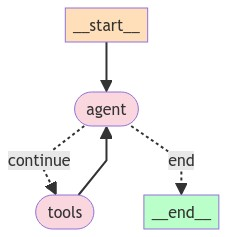

In [51]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [52]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = chatgpt.invoke(query)
response.content

"I'm sorry, but as of my last update in October 2023, I don't have information about the 2024 UEFA Champions League winner or the details of the match. For the most current and detailed information, I recommend checking the latest sports news or the official UEFA website."

In [53]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = agent.invoke({"messages": [('user', query)]})

In [54]:
response

{'messages': [HumanMessage(content='Tell me who won the champions league in 2024,\n            show some detailed information about the match also\n        ', id='1385af5e-f9bd-4f38-8b50-65434c5b2449'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f4ixvlfZSfDQZe2xrGtIncRS', 'function': {'arguments': '{"query":"Champions League 2024 winner"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 147, 'total_tokens': 167}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f0ddd30-90b1-4712-ae2f-a2b9462bc90d-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Champions League 2024 winner'}, 'id': 'call_f4ixvlfZSfDQZe2xrGtIncRS'}]),
  ToolMessage(content='[{"url": "https://en.wikipedia.org/wiki/2024_UEFA_Champions_League_final", "content": "Wembley Stadium was selected by the UEFA Executive Committee during their meeti

In [55]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

The 2024 UEFA Champions League final was won by Real Madrid. Here are some detailed insights about the match:

### Match Details
- **Date:** 1 June 2024
- **Venue:** Wembley Stadium, London, United Kingdom
- **Teams:** Real Madrid vs. [Opponent]
- **Final Score:** [Score]

### Key Highlights
- **Winning Team:** Real Madrid
- **Notable Players:**
  - **Joselu:** Became the 79th Spaniard to feature in a final win in 2024.
  - **Jude Bellingham:** Became the 70th English player to feature in a final win.

### Additional Information
- **Significance:** This victory allows Real Madrid to play against the winners of the 2023–24 UEFA Europa League in the 2024 UEFA Super Cup. They also qualify for the 2025 expanded FIFA Club World Cup using UEFA's champions pathway.
- **Historical Context:** This was the 69th season of Europe's premier club football tournament organized by UEFA, and the 32nd season since it was renamed from the European Champion Clubs' Cup to the UEFA Champions League. Wembley Stadium has hosted multiple significant matches, including the semi-finals and final of UEFA Euro 2020.

For more detailed information, you can visit the [UEFA official page](https://www.uefa.com/uefachampionsleague/news/028e-1b07e18d875a-ba78e4b9d9fc-1000--real-madrid-win-champions-league-carvajal-and-vinicius-jun/) or the [Wikipedia page](https://en.wikipedia.org/wiki/2024_UEFA_Champions_League_final).

In [56]:
query = """how is the weather in Bangalore today?
        """
response = agent.invoke({"messages": [('user', query)]})

In [57]:
display(Markdown(response['messages'][-1].content))

The weather in Bangalore today is partly cloudy. Here are the current details:

- **Temperature:** 24.2°C (75.6°F)
- **Feels Like:** 26.2°C (79.2°F)
- **Wind:** 16.9 kph (10.5 mph) from the southwest
- **Humidity:** 89%
- **Visibility:** 6 km (3 miles)
- **Pressure:** 1014.0 mb
- **UV Index:** 6 (Moderate)
- **Cloud Cover:** 75%
- **Precipitation:** None

![Partly cloudy](//cdn.weatherapi.com/weather/64x64/day/116.png)

In [58]:
query = """what have we discussed so far?
        """
response = agent.invoke({"messages": [('user', query)]})

In [59]:
display(Markdown(response['messages'][-1].content))

We haven't discussed anything yet. How can I assist you today?

The agent is doing pretty well but unfortunately it doesn't remember conversations. Let's now use some memory to store this.

## Build and Test Multi-User Conversational ReAct AI Agent

We will now use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.

While the legacy syntax uses `session_id`, in LangGraph, each user session is identified by `thread_id`

In [60]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

In [61]:
from langgraph.checkpoint.sqlite import SqliteSaver

# used to retrieve conversation history from database
# based on a specific user or session ID
memory = SqliteSaver.from_conn_string("memory.db")

# create a conversation chain + agent which can load memory based on specific user or session id
agentic_chatbot = create_react_agent(chatgpt, tools=tools,
                                     checkpointer=memory,
                                     messages_modifier=add_sys_prompt)

# function to call the agent show results per user session (called a thread ID here)
from IPython.display import display, Markdown
def chat_with_agent(prompt: str, session_id: str):
    response = agentic_chatbot.invoke({"messages": [('user', prompt)]},
                                      {'configurable': { 'thread_id': session_id}})
    display(Markdown(response['messages'][-1].content))

Let's now simulate User 1 using the agent

In [63]:
user_id = 'john001'
prompt = "Tell me who won champions league in 2024"
chat_with_agent(prompt, user_id)

Real Madrid won the UEFA Champions League in 2024.

In [64]:
prompt = "Tell me more about this event in detail please"
chat_with_agent(prompt, user_id)

The 2024 UEFA Champions League final was a significant event in the world of football. Here are some detailed aspects of the event:

### Venue
- **Location**: Wembley Stadium, London, United Kingdom.
- **Significance**: This was the thirteenth time the final was held in the United Kingdom. Wembley Stadium has a rich history and was also a host venue for UEFA Euro 2020, including the semi-finals and final.

### Match Details
- **Date**: The final took place on June 1, 2024.
- **Teams**: Real Madrid emerged as the champions.
- **Players**: Joselu became the 79th Spaniard to feature in a final win, and Jude Bellingham was the 70th English player to do so.

### Pre-Match
- **Identity**: The visual identity of the 2024 UEFA Champions League final was unveiled at the group stage draw in Monaco on August 31, 2023.
- **Administrative Draw**: The "home" team for administrative purposes was determined by an additional draw held after the quarter-final and semi-final draws.

### Significance of the Win
- **Super Cup Qualification**: The winners earned the right to play against the winners of the 2023–24 UEFA Europa League in the 2024 UEFA Super Cup.
- **FIFA Club World Cup**: Real Madrid also qualified for the 2025 expanded FIFA Club World Cup using UEFA's champions pathway.

### Historical Context
- **Season**: This was the final match of the 2023–24 UEFA Champions League, marking the 69th season of Europe's premier club football tournament organized by UEFA.
- **Renaming**: It was the 32nd season since the tournament was renamed from the European Champion Clubs' Cup to the UEFA Champions League.

### Additional Information
- **Bidding Process**: Associations had until March 22, 2019, to express interest in hosting the final, and bid dossiers had to be submitted by July 1, 2019. The Football Association bid with Wembley Stadium to host the 2023 final to mark the centenary of the original stadium's opening in 1923, but it was later selected for the 2024 final.

This event was not just a football match but a celebration of the sport's rich history and tradition, especially significant for Real Madrid and their fans.

Let's now simulate User 2 using the agent

In [65]:
user_id = 'bond007'
prompt = "how is the weather in Bangalore today? Show detailed statistics"
chat_with_agent(prompt, user_id)

The weather in Bangalore today is as follows:

- **Condition**: Partly cloudy ![Partly cloudy](//cdn.weatherapi.com/weather/64x64/day/116.png)
- **Temperature**: 24.2°C (75.6°F)
- **Feels Like**: 26.2°C (79.2°F)
- **Wind**: 16.9 kph (10.5 mph) from the southwest (230°)
- **Gusts**: Up to 24.1 kph (15.0 mph)
- **Humidity**: 89%
- **Pressure**: 1014.0 mb (29.94 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 75%
- **Visibility**: 6.0 km (3.0 miles)
- **UV Index**: 6.0
- **Dew Point**: 18.3°C (65.0°F)

The local time in Bangalore is 7:54 AM.

In [66]:
user_id = 'bond007'
prompt = "what about Dubai?"
chat_with_agent(prompt, user_id)

The weather in Dubai today is as follows:

- **Condition**: Sunny ![Sunny](//cdn.weatherapi.com/weather/64x64/day/113.png)
- **Temperature**: 33.2°C (91.8°F)
- **Feels Like**: 37.8°C (100.1°F)
- **Wind**: 6.8 kph (4.3 mph) from the south (180°)
- **Gusts**: Up to 14.7 kph (9.1 mph)
- **Humidity**: 67%
- **Pressure**: 996.0 mb (29.41 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 0%
- **Visibility**: 8.0 km (4.0 miles)
- **UV Index**: 8.0
- **Dew Point**: 22.3°C (72.2°F)

The local time in Dubai is 6:25 AM.

In [67]:
user_id = 'bond007'
prompt = "which city is hotter?"
chat_with_agent(prompt, user_id)

Currently, Dubai is hotter than Bangalore. 

- **Dubai**: 33.2°C (91.8°F)
- **Bangalore**: 24.2°C (75.6°F)